In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose

In [300]:
try:
    df_train = pd.read_csv("train.csv")
    df_features = pd.read_csv("features.csv")
    df_stores = pd.read_csv("stores.csv")
    df_test = pd.read_csv("test.csv")
except FileNotFoundError:
    print("File not found ...")
    exit()

In [301]:
data = pd.concat([df_train, df_test], ignore_index=True)

In [302]:
data = pd.merge(data, df_stores, how='left', on='Store')
data = pd.merge(data, df_features, how='left', on=['Store', 'Date', 'IsHoliday'])

In [303]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [304]:
train_df = data[data["Weekly_Sales"].notna()].copy()
val_df = data[data["Weekly_Sales"].isna()].copy()

In [305]:
train_keys = set(zip(train_df['Store'], train_df['Dept']))
val_keys = set(zip(val_df['Store'], val_df['Dept']))
common_keys = train_keys & val_keys

In [306]:
train_df = train_df[train_df[['Store', 'Dept']].apply(tuple, axis=1).isin(common_keys)].copy()
val_df = val_df[val_df[['Store', 'Dept']].apply(tuple, axis=1).isin(common_keys)].copy()

In [307]:
full_df = pd.concat([train_df, val_df]).sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [308]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536634 entries, 0 to 536633
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         536634 non-null  int64         
 1   Dept          536634 non-null  int64         
 2   Date          536634 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     536634 non-null  bool          
 5   Type          536634 non-null  object        
 6   Size          536634 non-null  int64         
 7   Temperature   536634 non-null  float64       
 8   Fuel_Price    536634 non-null  float64       
 9   MarkDown1     265596 non-null  float64       
 10  MarkDown2     197685 non-null  float64       
 11  MarkDown3     242326 non-null  float64       
 12  MarkDown4     237143 non-null  float64       
 13  MarkDown5     266496 non-null  float64       
 14  CPI           498472 non-null  float64       
 15  Unemployment  498

In [309]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,536634.000000,536634.000000,536634,421570.000000,536634.000000,536634.000000,536634.000000,265596.000000,197685.000000,242326.000000,237143.000000,266496.000000,498472.000000,498472.000000
mean,22.208621,44.277301,2011-11-01 13:33:31.458088704,15981.258123,136678.550960,58.771762,3.408310,7438.004144,3509.274827,1857.913525,3371.556866,4324.021158,172.090481,7.791888
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,11.000000,18.000000,2010-12-17 00:00:00,2079.650000,93638.000000,45.250000,3.041000,2114.640000,72.500000,7.220000,336.240000,1570.112500,132.521867,6.623000
50%,22.000000,37.000000,2011-11-04 00:00:00,7612.030000,140167.000000,60.060000,3.523000,5126.540000,385.310000,40.760000,1239.040000,2870.910000,182.442420,7.795000
75%,33.000000,74.000000,2012-09-14 00:00:00,20205.852500,202505.000000,73.230000,3.744000,9303.850000,2392.390000,174.260000,3397.080000,5012.220000,213.748126,8.549000
max,45.000000,99.000000,2013-07-26 00:00:00,693099.360000,219622.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000
std,12.790580,30.527358,NaN,22711.183519,61007.711799,18.678716,0.430861,9411.341379,8992.047197,11616.143274,6872.281734,13549.262124,39.542149,1.865076


<Axes: xlabel='Date'>

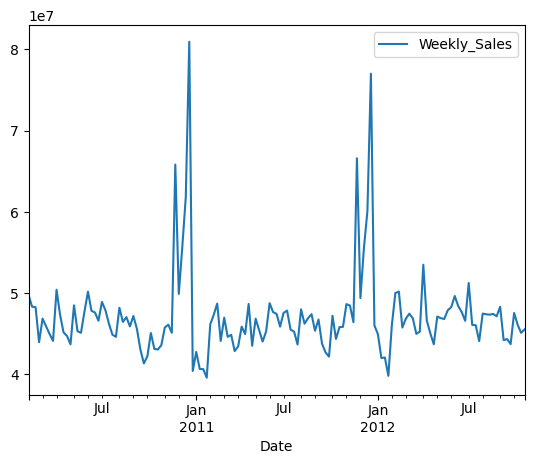

In [310]:
data[["Date","Weekly_Sales"]][data["Weekly_Sales"].notna()].groupby("Date").sum().reset_index().plot("Date","Weekly_Sales",kind='line')

<Axes: xlabel='Store'>

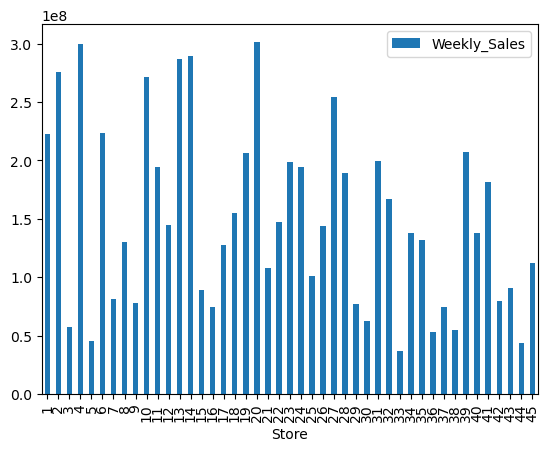

In [311]:
data[["Store","Weekly_Sales"]][data["Weekly_Sales"].notna()].groupby("Store").sum().reset_index().plot("Store","Weekly_Sales",kind='bar')

<Axes: xlabel='IsHoliday'>

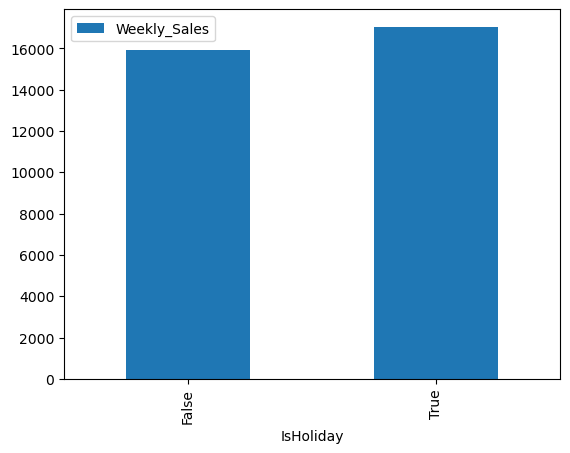

In [312]:
data[["IsHoliday","Weekly_Sales"]][data["Weekly_Sales"].notna()].groupby('IsHoliday').mean().reset_index().plot("IsHoliday","Weekly_Sales",kind='bar')

# Feature engineering

In [313]:
for col in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']:
    full_df[col] = full_df[col].fillna(0)

In [314]:
full_df['CPI'] = full_df.groupby('Store')['CPI'].transform(lambda x: x.fillna(x.median()))
full_df['Unemployment'] = full_df.groupby('Store')['Unemployment'].transform(lambda x: x.fillna(x.median()))

In [315]:
full_df["Type"] = full_df["Type"].map({"A": 1, "B": 2, "C": 3}).astype('int8')

In [262]:
full_df['IsHoliday'] = full_df['IsHoliday'].astype('int8')

In [263]:
full_df['year'] = full_df['Date'].dt.year
full_df['month'] = full_df['Date'].dt.month
full_df['week'] = full_df['Date'].dt.isocalendar().week
full_df['is_month_start'] = full_df['Date'].dt.is_month_start.astype(int)
full_df['is_month_end'] = full_df['Date'].dt.is_month_end.astype(int)

In [264]:
for lag in [1, 2, 3]:
    full_df[f'Weekly_Sales_Lag_{lag}'] = (
        full_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)
    )

for window in [4, 8]:
    full_df[f'Weekly_Sales_Rolling_{window}'] = (
        full_df.groupby(['Store', 'Dept'], group_keys=False)['Weekly_Sales']
        .apply(lambda x: x.shift(1).rolling(window=window).mean())
    )

In [271]:
final_train = full_df[full_df["Weekly_Sales"].notna()].reset_index(drop=True)
final_val = full_df[full_df["Weekly_Sales"].isna()].reset_index(drop=True)

In [272]:
final_train["Trend"] = np.nan
final_train["Seasonality"] = np.nan

for (store, dept), group in final_train.groupby(["Store", "Dept"]):
    group = group.sort_values("Date")
    
    group = group.dropna(subset=["Weekly_Sales"])
    
    if len(group) < 104:
        continue
    
    result = seasonal_decompose(
        group["Weekly_Sales"], 
        model='additive', 
        period=52, 
        extrapolate_trend='freq'
    )

    final_train.loc[group.index, "Trend"] = result.trend
    final_train.loc[group.index, "Seasonality"] = result.seasonal


In [273]:
final_val["Trend"] = np.nan
final_val["Seasonality"] = np.nan

for (store, dept), group in final_val.groupby(["Store", "Dept"]):
    group = group.sort_values("Date")

    train_group = final_train[(final_train["Store"] == store) & (final_train["Dept"] == dept)].sort_values("Date")

    if train_group["Trend"].isna().all() or train_group["Seasonality"].isna().all():
        continue

    last_trend = train_group["Trend"].dropna().iloc[-4:].mean()

    seasonal_pattern = train_group["Seasonality"].dropna().iloc[-52:].values
    seasonal_values = np.resize(seasonal_pattern, len(group)) 

    final_val.loc[group.index, "Trend"] = last_trend
    final_val.loc[group.index, "Seasonality"] = seasonal_values


In [274]:
X_train = final_train.drop(columns=["Weekly_Sales","Date"]).dropna()
Y_train = final_train.dropna()["Weekly_Sales"]
X_test = final_val.drop(columns=["Weekly_Sales","Date"])

# Modeling

In [276]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

### linear regression

In [277]:
model = LinearRegression().fit(X_train,Y_train)

In [278]:
model.score(X_train,Y_train)

0.9908781452620035

In [279]:
mae = mean_absolute_error(Y_train, model.predict(X_train))
rmse = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 951.7558215540591
RMSE: 2191.430371562683


### XGBoost 

In [221]:
param_grid = {
    'n_estimators' : [150,200,250],
    'max_depth': [9, 7 , 8],
    'learning_rate': [0.1 , 0.15 , 0.12 , 0.08],
}

In [ ]:
xgb = XGBRegressor()
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train,Y_train)

In [ ]:
print(grid.best_params_)

In [281]:
xgb = XGBRegressor(learning_rate = 0.15 , max_depth = 7 , n_estimators = 250).fit(X_train,Y_train)

In [282]:
xgb.score(X_train, Y_train)

0.9961820515069703

In [283]:
Y_pred = xgb.predict(X_train)
mae = mean_absolute_error(Y_train, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 774.1095020266938
RMSE: 1417.7548215455972


### lightgbm

In [285]:
lgb = LGBMRegressor(learning_rate = 0.15 , max_depth = -1 , n_estimators = 250).fit(X_train.drop(columns=["Seasonality","Trend","Weekly_Sales_Lag_1", "Weekly_Sales_Lag_2", "Weekly_Sales_Lag_3", "Weekly_Sales_Rolling_4", "Weekly_Sales_Rolling_8"]),Y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 384041, number of used features: 19
[LightGBM] [Info] Start training from score 16561.832257


In [286]:
lgb.score(X_train.drop(columns=["Seasonality","Trend","Weekly_Sales_Lag_1", "Weekly_Sales_Lag_2", "Weekly_Sales_Lag_3", "Weekly_Sales_Rolling_4", "Weekly_Sales_Rolling_8"]), Y_train)

0.9604910080782049

In [287]:
Y_pred = lgb.predict(X_train.drop(columns=["Seasonality","Trend","Weekly_Sales_Lag_1", "Weekly_Sales_Lag_2", "Weekly_Sales_Lag_3", "Weekly_Sales_Rolling_4", "Weekly_Sales_Rolling_8"]))
mae = mean_absolute_error(Y_train, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2790.485582018313
RMSE: 4560.726979825853


In [291]:
def predict_sales(X):
    lag_cols = ["Weekly_Sales_Lag_1","Weekly_Sales_Lag_2","Weekly_Sales_Lag_3","Weekly_Sales_Rolling_4","Weekly_Sales_Rolling_8","Seasonality","Trend"]

    no_lag_idx = X[X[lag_cols].isna().any(axis=1)].index
    lag_idx = X.drop(index=no_lag_idx).index

    preds = pd.Series(index=X.index, dtype='float64')

    if len(lag_idx) > 0:
        preds.loc[lag_idx] = xgb.predict(X.loc[lag_idx])

    if len(no_lag_idx) > 0:
        X_no_lag = X.drop(columns=lag_cols).loc[no_lag_idx]
        preds.loc[no_lag_idx] = lgb.predict(X_no_lag)

    return preds

In [292]:
submission = pd.DataFrame({
    'Weekly_Sales': predict_sales(X_test)
})
submission.to_csv('submission.csv', index=True)

In [235]:
predicted = xgb.predict(X_train)

In [236]:
df = pd.DataFrame({"Date" : final_train.dropna()['Date'] ,
                  "Actual" : final_train.dropna()['Weekly_Sales'],
                  "predicted" : predicted})

In [237]:
a = df[['Date','Actual']].groupby("Date").sum().reset_index()['Actual']
d = df[['Date','Actual']].groupby("Date").sum().reset_index()['Date']
p = df[['Date','predicted']].groupby("Date").sum().reset_index()['predicted']

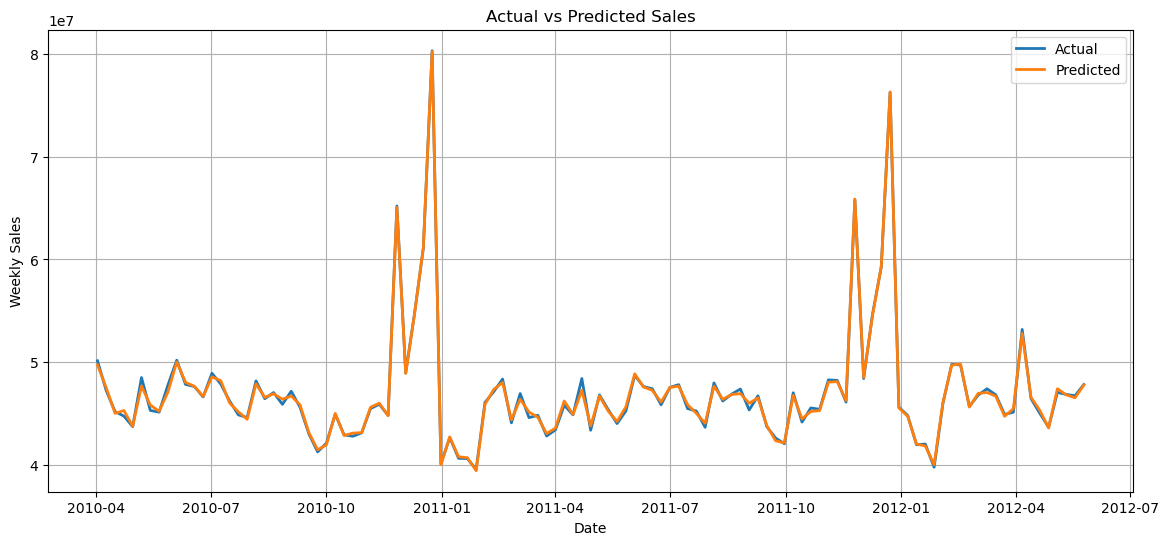

In [238]:
plt.figure(figsize=(14,6))
plt.plot(d, a, label='Actual', linewidth=2)
plt.plot(d, p, label='Predicted', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()